# Tugas Kelompok – Fuzzy Mamdani (Beasiswa)

Notebook ini berisi implementasi **Inferensi Mamdani** untuk studi kasus **Pemberian Beasiswa**.

Alur:
1. Fuzzifikasi (TOEFL, IPK, Penghasilan Ortu)
2. Evaluasi rule (AND = min, OR = max)
3. Implikasi (clipping = min)
4. Agregasi (max)
5. Defuzzifikasi (centroid)

.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1) Data Mahasiswa

In [ ]:
data = [
    ("01","Toyes",450,4,750_000),
    ("02","Bowo",480,3,1_500_000),
    ("03","Erna",360,3,1_255_000),
    ("04","Astuti",270,2,1_040_000),
    ("05","Yuni",420,4,950_000),
    ("06","Heribertus",390,4,1_600_000),
    ("07","Edy",370,3,1_250_000),
    ("08","Usman",255,3,550_000),
    ("09","Pujiono",325,2,735_000),
    ("10","Slamet",250,1,860_000),
]

df = pd.DataFrame(data, columns=["NIM","Nama","TOEFL","IPK","Penghasilan"])
df

,NIM,Nama,TOEFL,IPK,Penghasilan
0,01,Toyes,450,4,750000
1,02,Bowo,480,3,1500000
2,03,Erna,360,3,1255000
3,04,Astuti,270,2,1040000
4,05,Yuni,420,4,950000
5,06,Heribertus,390,4,1600000
6,07,Edy,370,3,1250000
7,08,Usman,255,3,550000
8,09,Pujiono,325,2,735000
9,10,Slamet,250,1,860000


## 2) Helper: pembatas nilai derajat keanggotaan (0..1)

In [ ]:
def clamp01(v: float) -> float:
    """Pastikan derajat keanggotaan berada pada rentang [0, 1]."""
    return max(0.0, min(1.0, float(v)))

## 3) Fungsi Keanggotaan Input

> Bentuk MF input di bawah adalah versi yang rapi dan konsisten untuk perhitungan Mamdani.
Jika dosenmu punya parameter/titik yang berbeda, kamu bisa menyesuaikan angka-angka batasnya,
tanpa mengubah alur inferensinya.


In [ ]:
# =========================
# TOEFL (0..500)
# =========================

def fuzz_toefl_menengah(x: float) -> float:
    """Segitiga: (250, 350, 450)"""
    if x <= 250 or x >= 450:
        return 0.0
    elif 250 < x <= 350:
        return clamp01((x - 250) / 100)
    else:  # 350 < x < 450
        return clamp01((450 - x) / 100)

def fuzz_toefl_tinggi(x: float) -> float:
    """Naik: 350->450, lalu 1"""
    if x <= 350:
        return 0.0
    elif 350 < x < 450:
        return clamp01((x - 350) / 100)
    else:
        return 1.0


# =========================
# IPK (0..4)
# =========================

def fuzz_ipk_cukup(x: float) -> float:
    """Segitiga: (1.0, 2.5, 4.0)"""
    if x <= 1.0 or x >= 4.0:
        return 0.0
    elif 1.0 < x <= 2.5:
        return clamp01((x - 1.0) / 1.5)
    else:  # 2.5 < x < 4.0
        return clamp01((4.0 - x) / 1.5)

def fuzz_ipk_bagus(x: float) -> float:
    """Naik: 3.0->3.5, lalu 1"""
    if x <= 3.0:
        return 0.0
    elif 3.0 < x < 3.5:
        return clamp01((x - 3.0) / 0.5)
    else:
        return 1.0


# =========================
# Penghasilan Ortu (dalam rupiah)
# Untuk rule di slide: (kecil OR sedang) dan (besar OR sangat besar)
# Kita gabungkan jadi 2 himpunan: kecil_sedang dan besar_sangat_besar.
# =========================

def fuzz_penghasilan_kecil_sedang(penghasilan_rp: float) -> float:
    """Trapesium sederhana: <= 0.5 jt = 1, turun linear ke 0 di 1.2 jt"""
    x = penghasilan_rp / 1_000_000  # konversi ke juta
    if x <= 0.5:
        return 1.0
    elif 0.5 < x < 1.2:
        return clamp01((1.2 - x) / (1.2 - 0.5))
    else:
        return 0.0

def fuzz_penghasilan_besar_sangat_besar(penghasilan_rp: float) -> float:
    """Naik: 1.0 jt -> 1.5 jt, lalu 1"""
    x = penghasilan_rp / 1_000_000
    if x <= 1.0:
        return 0.0
    elif 1.0 < x < 1.5:
        return clamp01((x - 1.0) / 0.5)
    else:
        return 1.0

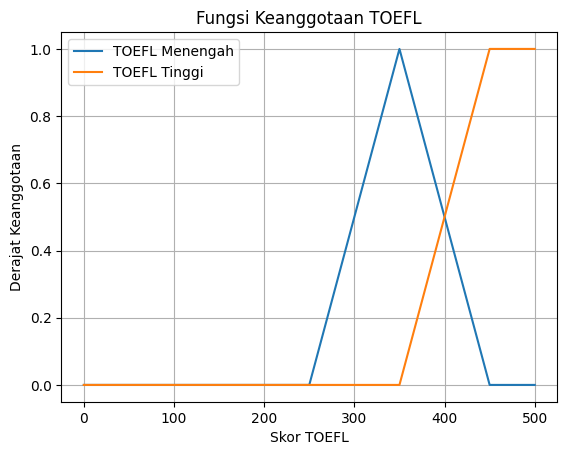

In [ ]:
# 1) TOEFL
x_toefl = np.linspace(0, 500, 501)
mu_toefl_menengah = [fuzz_toefl_menengah(x) for x in x_toefl]
mu_toefl_tinggi   = [fuzz_toefl_tinggi(x) for x in x_toefl]

plt.figure()
plt.plot(x_toefl, mu_toefl_menengah, label="TOEFL Menengah")
plt.plot(x_toefl, mu_toefl_tinggi,   label="TOEFL Tinggi")
plt.title("Fungsi Keanggotaan TOEFL")
plt.xlabel("Skor TOEFL")
plt.ylabel("Derajat Keanggotaan")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

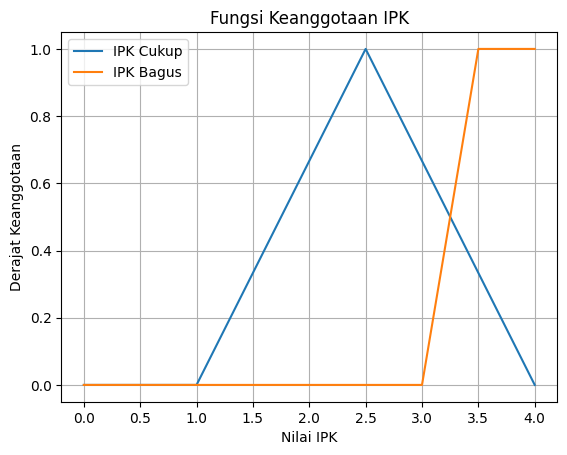

In [ ]:
# 2) IPK
x_ipk = np.linspace(0, 4, 401)
mu_ipk_cukup = [fuzz_ipk_cukup(x) for x in x_ipk]
mu_ipk_bagus = [fuzz_ipk_bagus(x) for x in x_ipk]

plt.figure()
plt.plot(x_ipk, mu_ipk_cukup, label="IPK Cukup")
plt.plot(x_ipk, mu_ipk_bagus, label="IPK Bagus")
plt.title("Fungsi Keanggotaan IPK")
plt.xlabel("Nilai IPK")
plt.ylabel("Derajat Keanggotaan")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

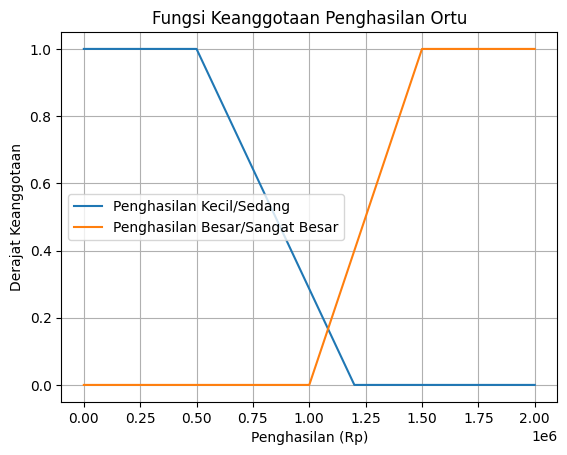

In [ ]:

# 3) Penghasilan Ortu (dalam Rupiah)
x_inc = np.linspace(0, 2_000_000, 401)
mu_inc_kecil_sedang = [fuzz_penghasilan_kecil_sedang(x) for x in x_inc]
mu_inc_besar_sbesar = [fuzz_penghasilan_besar_sangat_besar(x) for x in x_inc]

plt.figure()
plt.plot(x_inc, mu_inc_kecil_sedang, label="Penghasilan Kecil/Sedang")
plt.plot(x_inc, mu_inc_besar_sbesar, label="Penghasilan Besar/Sangat Besar")
plt.title("Fungsi Keanggotaan Penghasilan Ortu")
plt.xlabel("Penghasilan (Rp)")
plt.ylabel("Derajat Keanggotaan")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

## 4) Fungsi Keanggotaan Output (Nilai Kelayakan) – sesuai grafik slide

In [ ]:
# Domain output: z dalam [0, 100]

def fuzz_kelayakan_rendah(z: float) -> float:
    """Rendah: 1 untuk z<=50, turun ke 0 di z=80"""
    if z <= 50:
        return 1.0
    elif 50 < z < 80:
        return clamp01((80 - z) / 30)
    else:
        return 0.0

def fuzz_kelayakan_tinggi(z: float) -> float:
    """Tinggi: 0 untuk z<=50, naik ke 1 di z=80, lalu 1"""
    if z <= 50:
        return 0.0
    elif 50 < z < 80:
        return clamp01((z - 50) / 30)
    else:
        return 1.0

## 5) Plot Fungsi Keanggotaan (opsional)

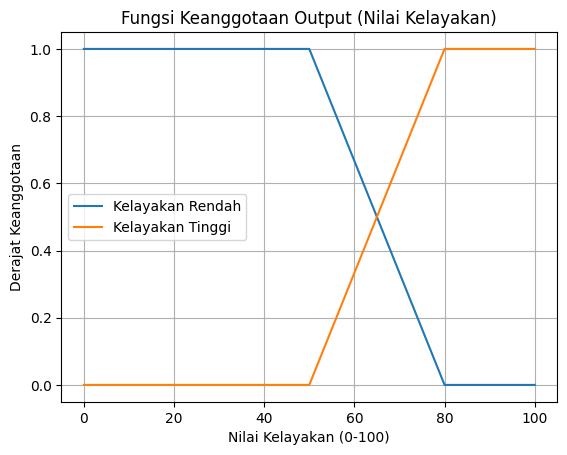

In [ ]:
# Plot output (koreksi sesuai slide)
z = np.linspace(0, 100, 501)
mu_low  = [fuzz_kelayakan_rendah(v) for v in z]
mu_high = [fuzz_kelayakan_tinggi(v) for v in z]

plt.figure()
plt.plot(z, mu_low,  label="Kelayakan Rendah")
plt.plot(z, mu_high, label="Kelayakan Tinggi")
plt.title("Fungsi Keanggotaan Output (Nilai Kelayakan)")
plt.xlabel("Nilai Kelayakan (0-100)")
plt.ylabel("Derajat Keanggotaan")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

## 6) Rule Base (sesuai slide) + Inferensi Mamdani

In [ ]:
# Rule base:
# R1: IF IPK bagus AND (penghasilan kecil/sedang) THEN kelayakan tinggi
# R2: IF IPK bagus AND (penghasilan besar/sangat besar) THEN kelayakan rendah
# R3: IF IPK cukup AND (penghasilan kecil/sedang) THEN kelayakan rendah
# R4: IF TOEFL tinggi AND (penghasilan kecil/sedang) THEN kelayakan tinggi
# R5: IF TOEFL menengah AND (penghasilan kecil/sedang) THEN kelayakan tinggi

Z_UNIV = np.arange(0, 101, 1)

def mamdani_kelayakan(toefl: float, ipk: float, penghasilan_rp: float):
    # ---------- fuzzifikasi ----------
    mu_ipk_bagus = fuzz_ipk_bagus(ipk)
    mu_ipk_cukup = fuzz_ipk_cukup(ipk)
    mu_toefl_tinggi = fuzz_toefl_tinggi(toefl)
    mu_toefl_menengah = fuzz_toefl_menengah(toefl)
    mu_inc_kecil_sedang = fuzz_penghasilan_kecil_sedang(penghasilan_rp)
    mu_inc_besar_sbesar = fuzz_penghasilan_besar_sangat_besar(penghasilan_rp)

    # ---------- firing strength (AND=min, OR=max) ----------
    a1 = min(mu_ipk_bagus, mu_inc_kecil_sedang)  # -> tinggi
    a2 = min(mu_ipk_bagus, mu_inc_besar_sbesar)  # -> rendah
    a3 = min(mu_ipk_cukup, mu_inc_kecil_sedang)  # -> rendah
    a4 = min(mu_toefl_tinggi, mu_inc_kecil_sedang)  # -> tinggi
    a5 = min(mu_toefl_menengah, mu_inc_kecil_sedang)  # -> tinggi

    alpha_tinggi = max(a1, a4, a5)
    alpha_rendah = max(a2, a3)

    # ---------- implikasi + agregasi output ----------
    mu_agregasi = []
    for z in Z_UNIV:
        # clipping
        out_tinggi = min(alpha_tinggi, fuzz_kelayakan_tinggi(z))
        out_rendah = min(alpha_rendah, fuzz_kelayakan_rendah(z))
        # agregasi (max)
        mu_agregasi.append(max(out_tinggi, out_rendah))
    mu_agregasi = np.array(mu_agregasi, dtype=float)

    # ---------- centroid ----------
    if mu_agregasi.sum() == 0:
        z_star = 0.0
    else:
        z_star = (Z_UNIV * mu_agregasi).sum() / mu_agregasi.sum()

    detail = {
        "mu_ipk_bagus": mu_ipk_bagus,
        "mu_ipk_cukup": mu_ipk_cukup,
        "mu_toefl_tinggi": mu_toefl_tinggi,
        "mu_toefl_menengah": mu_toefl_menengah,
        "mu_inc_kecil_sedang": mu_inc_kecil_sedang,
        "mu_inc_besar_sbesar": mu_inc_besar_sbesar,
        "a1_R1": a1, "a2_R2": a2, "a3_R3": a3, "a4_R4": a4, "a5_R5": a5,
        "alpha_tinggi": alpha_tinggi,
        "alpha_rendah": alpha_rendah,
    }
    return z_star, mu_agregasi, detail

### 6B Clipping, dan Agregasi

In [ ]:
def mamdani_kelayakan_debug(toefl: float, ipk: float, penghasilan_rp: float, z_step: int = 1):
    """Mengembalikan semua tahapan Mamdani (untuk kebutuhan laporan)."""
    Z = np.arange(0, 101, z_step)

    # ---------- fuzzifikasi ----------
    mu_ipk_bagus = fuzz_ipk_bagus(ipk)
    mu_ipk_cukup = fuzz_ipk_cukup(ipk)
    mu_toefl_tinggi = fuzz_toefl_tinggi(toefl)
    mu_toefl_menengah = fuzz_toefl_menengah(toefl)
    mu_inc_kecil_sedang = fuzz_penghasilan_kecil_sedang(penghasilan_rp)
    mu_inc_besar_sbesar = fuzz_penghasilan_besar_sangat_besar(penghasilan_rp)

    # ---------- firing strength (AND=min) ----------
    a1 = min(mu_ipk_bagus, mu_inc_kecil_sedang)         # R1 -> tinggi
    a2 = min(mu_ipk_bagus, mu_inc_besar_sbesar)         # R2 -> rendah
    a3 = min(mu_ipk_cukup, mu_inc_kecil_sedang)         # R3 -> rendah
    a4 = min(mu_toefl_tinggi, mu_inc_kecil_sedang)      # R4 -> tinggi
    a5 = min(mu_toefl_menengah, mu_inc_kecil_sedang)    # R5 -> tinggi

    # ---------- clipping per-rule ----------
    clip_R1_tinggi = np.array([min(a1, fuzz_kelayakan_tinggi(z)) for z in Z], dtype=float)
    clip_R4_tinggi = np.array([min(a4, fuzz_kelayakan_tinggi(z)) for z in Z], dtype=float)
    clip_R5_tinggi = np.array([min(a5, fuzz_kelayakan_tinggi(z)) for z in Z], dtype=float)

    clip_R2_rendah = np.array([min(a2, fuzz_kelayakan_rendah(z)) for z in Z], dtype=float)
    clip_R3_rendah = np.array([min(a3, fuzz_kelayakan_rendah(z)) for z in Z], dtype=float)

    # ---------- agregasi per-konsekuen (MAX) ----------
    agg_tinggi = np.maximum.reduce([clip_R1_tinggi, clip_R4_tinggi, clip_R5_tinggi])
    agg_rendah = np.maximum.reduce([clip_R2_rendah, clip_R3_rendah])

    # ---------- agregasi final ----------
    mu_agregasi = np.maximum(agg_tinggi, agg_rendah)

    # ---------- centroid ----------
    if mu_agregasi.sum() == 0:
        z_star = 0.0
    else:
        z_star = (Z * mu_agregasi).sum() / mu_agregasi.sum()

    detail = {
        # fuzzifikasi
        "mu_ipk_bagus": mu_ipk_bagus,
        "mu_ipk_cukup": mu_ipk_cukup,
        "mu_toefl_tinggi": mu_toefl_tinggi,
        "mu_toefl_menengah": mu_toefl_menengah,
        "mu_inc_kecil_sedang": mu_inc_kecil_sedang,
        "mu_inc_besar_sbesar": mu_inc_besar_sbesar,
        # alpha rules
        "a1_R1_tinggi": a1,
        "a2_R2_rendah": a2,
        "a3_R3_rendah": a3,
        "a4_R4_tinggi": a4,
        "a5_R5_tinggi": a5,
        # arrays
        "Z": Z,
        "clip_R1_tinggi": clip_R1_tinggi,
        "clip_R4_tinggi": clip_R4_tinggi,
        "clip_R5_tinggi": clip_R5_tinggi,
        "clip_R2_rendah": clip_R2_rendah,
        "clip_R3_rendah": clip_R3_rendah,
        "agg_tinggi": agg_tinggi,
        "agg_rendah": agg_rendah,
        "mu_agregasi": mu_agregasi,
        "z_star": z_star,
    }
    return detail


In [ ]:
def tampilkan_tabel_mamdani(detail: dict) -> pd.DataFrame:
    """Membuat tabel z berisi clipping, agregasi, dan agregasi final."""
    Z = detail["Z"]
    return pd.DataFrame({
        "z": Z,
        "clip_R1_tinggi": detail["clip_R1_tinggi"],
        "clip_R4_tinggi": detail["clip_R4_tinggi"],
        "clip_R5_tinggi": detail["clip_R5_tinggi"],
        "agg_tinggi": detail["agg_tinggi"],
        "clip_R2_rendah": detail["clip_R2_rendah"],
        "clip_R3_rendah": detail["clip_R3_rendah"],
        "agg_rendah": detail["agg_rendah"],
        "agregasi_final": detail["mu_agregasi"],
    })


In [ ]:
# Pilih NIM yang ingin dianalisis (ubah sesuai kebutuhan)
nim_pilih = "01"
row = df[df["NIM"] == nim_pilih].iloc[0]

detail = mamdani_kelayakan_debug(
    toefl=float(row["TOEFL"]),
    ipk=float(row["IPK"]),
    penghasilan_rp=float(row["Penghasilan"]),
    z_step=5  # step 5 (0,5,10,...,100)
)

print("=== FUZZIFIKASI ===")
print("mu_ipk_bagus       :", detail["mu_ipk_bagus"])
print("mu_ipk_cukup        :", detail["mu_ipk_cukup"])
print("mu_toefl_tinggi     :", detail["mu_toefl_tinggi"])
print("mu_toefl_menengah   :", detail["mu_toefl_menengah"])
print("mu_inc_kecil_sedang :", detail["mu_inc_kecil_sedang"])
print("mu_inc_besar_sbesar :", detail["mu_inc_besar_sbesar"])

print("\n=== FIRING STRENGTH (α) ===")
print("α1 R1 -> tinggi:", detail["a1_R1_tinggi"])
print("α2 R2 -> rendah:", detail["a2_R2_rendah"])
print("α3 R3 -> rendah:", detail["a3_R3_rendah"])
print("α4 R4 -> tinggi:", detail["a4_R4_tinggi"])
print("α5 R5 -> tinggi:", detail["a5_R5_tinggi"])

print("\nCentroid (z*):", detail["z_star"])

tabel = tampilkan_tabel_mamdani(detail)
tabel


=== FUZZIFIKASI ===
mu_ipk_bagus       : 1.0
mu_ipk_cukup        : 0.0
mu_toefl_tinggi     : 1.0
mu_toefl_menengah   : 0.0
mu_inc_kecil_sedang : 0.6428571428571428
mu_inc_besar_sbesar : 0.0

=== FIRING STRENGTH (α) ===
α1 R1 -> tinggi: 0.6428571428571428
α2 R2 -> rendah: 0.0
α3 R3 -> rendah: 0.0
α4 R4 -> tinggi: 0.6428571428571428
α5 R5 -> tinggi: 0.0

Centroid (z*): 80.75757575757576


,z,clip_R1_tinggi,clip_R4_tinggi,clip_R5_tinggi,agg_tinggi,clip_R2_rendah,clip_R3_rendah,agg_rendah,agregasi_final
0,0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,15,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
4,20,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
5,25,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
6,30,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
7,35,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
8,40,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
9,45,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


## 7) Hitung Nilai Kelayakan untuk Semua Mahasiswa + Ranking

In [ ]:
hasil = []
for _, r in df.iterrows():
    z_star, mu_ag, det = mamdani_kelayakan(r["TOEFL"], r["IPK"], r["Penghasilan"])
    hasil.append({
        "NIM": r["NIM"],
        "Nama": r["Nama"],
        "TOEFL": r["TOEFL"],
        "IPK": r["IPK"],
        "Penghasilan": r["Penghasilan"],
        "Nilai Kelayakan": float(z_star),
        "αR1": det["a1_R1"],
        "αR2": det["a2_R2"],
        "αR3": det["a3_R3"],
        "αR4": det["a4_R4"],
        "αR5": det["a5_R5"],
    })

res = pd.DataFrame(hasil)
res_sorted = res.sort_values("Nilai Kelayakan", ascending=False).reset_index(drop=True)
res_sorted

,NIM,Nama,TOEFL,IPK,Penghasilan,Nilai Kelayakan,αR1,αR2,αR3,αR4,αR5
0,01,Toyes,450,4,750000,79.694470,0.642857,0.0,0.000000,0.642857,0.000000
1,05,Yuni,420,4,950000,77.827179,0.357143,0.0,0.000000,0.357143,0.300000
2,09,Pujiono,325,2,735000,49.816258,0.000000,0.0,0.664286,0.000000,0.664286
3,04,Astuti,270,2,1040000,48.720871,0.000000,0.0,0.228571,0.000000,0.200000
4,08,Usman,255,3,550000,36.202843,0.000000,0.0,0.666667,0.000000,0.050000
5,06,Heribertus,390,4,1600000,32.821883,0.000000,1.0,0.000000,0.000000,0.000000
6,02,Bowo,480,3,1500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,03,Erna,360,3,1255000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8,07,Edy,370,3,1250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
9,10,Slamet,250,1,860000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


## 8) Visualisasi Agregasi Output untuk 1 Mahasiswa (opsional)

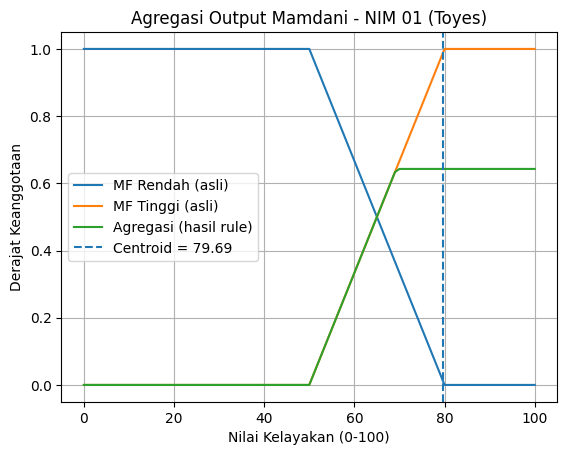

Detail fuzzifikasi & firing strength:
mu_ipk_bagus        : 1.0000
mu_ipk_cukup        : 0.0000
mu_toefl_tinggi     : 1.0000
mu_toefl_menengah   : 0.0000
mu_inc_kecil_sedang : 0.6429
mu_inc_besar_sbesar : 0.0000
a1_R1               : 0.6429
a2_R2               : 0.0000
a3_R3               : 0.0000
a4_R4               : 0.6429
a5_R5               : 0.0000
alpha_tinggi        : 0.6429
alpha_rendah        : 0.0000


In [ ]:
# Pilih NIM yang ingin dianalisis detail
nim_pilih = "01"
row = df[df["NIM"] == nim_pilih].iloc[0]
z_star, mu_ag, det = mamdani_kelayakan(row["TOEFL"], row["IPK"], row["Penghasilan"])

plt.figure()
plt.plot(Z_UNIV, [fuzz_kelayakan_rendah(z) for z in Z_UNIV], label="MF Rendah (asli)")
plt.plot(Z_UNIV, [fuzz_kelayakan_tinggi(z) for z in Z_UNIV], label="MF Tinggi (asli)")
plt.plot(Z_UNIV, mu_ag, label="Agregasi (hasil rule)")
plt.axvline(z_star, linestyle="--", label=f"Centroid = {z_star:.2f}")
plt.title(f"Agregasi Output Mamdani - NIM {nim_pilih} ({row['Nama']})")
plt.xlabel("Nilai Kelayakan (0-100)")
plt.ylabel("Derajat Keanggotaan")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
plt.show()

print("Detail fuzzifikasi & firing strength:")
for k, v in det.items():
    print(f"{k:20s}: {v:.4f}" if isinstance(v, float) else f"{k:20s}: {v}")

# METODE SUGENO

In [ ]:
def clamp01(v: float) -> float:
    """Pastikan nilai berada di [0,1]"""
    return max(0.0, min(1.0, float(v)))

fuzifikasi input

In [ ]:
# TOEFL (0-500)
def fuzz_toefl_menengah(x: float) -> float:
    """Segitiga: (250, 350, 450)"""
    if x <= 250 or x >= 450:
        return 0.0
    elif 250 < x <= 350:
        return clamp01((x - 250) / 100)
    else:
        return clamp01((450 - x) / 100)

def fuzz_toefl_tinggi(x: float) -> float:
    """Naik dari 350->450"""
    if x <= 350:
        return 0.0
    elif 350 < x < 450:
        return clamp01((x - 350) / 100)
    else:
        return 1.0

# IPK (0-4)
def fuzz_ipk_cukup(x: float) -> float:
    """Segitiga: (1.0, 2.5, 4.0)"""
    if x <= 1.0 or x >= 4.0:
        return 0.0
    elif 1.0 < x <= 2.5:
        return clamp01((x - 1.0) / 1.5)
    else:
        return clamp01((4.0 - x) / 1.5)

def fuzz_ipk_bagus(x: float) -> float:
    """Naik dari 3.0->3.5"""
    if x <= 3.0:
        return 0.0
    elif 3.0 < x < 3.5:
        return clamp01((x - 3.0) / 0.5)
    else:
        return 1.0

# Penghasilan (dalam rupiah)
def fuzz_penghasilan_kecil_sedang(penghasilan_rp: float) -> float:
    """<= 0.5jt = 1, turun ke 0 di 1.2jt"""
    x = penghasilan_rp / 1_000_000
    if x <= 0.5:
        return 1.0
    elif 0.5 < x < 1.2:
        return clamp01((1.2 - x) / 0.7)
    else:
        return 0.0

def fuzz_penghasilan_besar_sangat_besar(penghasilan_rp: float) -> float:
    """Naik dari 1.0jt->1.5jt"""
    x = penghasilan_rp / 1_000_000
    if x <= 1.0:
        return 0.0
    elif 1.0 < x < 1.5:
        return clamp01((x - 1.0) / 0.5)
    else:
        return 1.0

# Untuk kasus ini, kita definisikan konsekuen berdasarkan rule:
# - Rule yang menuju "TINGGI" → z = 0.5*kecepatan + 1700 (dari slide z1)
# - Rule yang menuju "RENDAH" → z = 2*kecepatan - 4000 (dari slide z2)
#
# Kita adaptasi untuk variabel kita (TOEFL, IPK, Penghasilan):

def konsekuen_tinggi(toefl: float, ipk: float, penghasilan: float) -> float:
    """
    Konsekuen untuk kelayakan TINGGI
    Berdasarkan slide: z = 0.5*kecepatan + 1700
    Adaptasi: z = 0.5*toefl + ipk*200 + 1700
    """
    return 0.5 * toefl + ipk * 200 + 1700

def konsekuen_rendah(toefl: float, ipk: float, penghasilan: float) -> float:
    """
    Konsekuen untuk kelayakan RENDAH
    Berdasarkan slide: z = 2*kecepatan - 4000
    Adaptasi: z = kecepatan + 700
    """
    return toefl / 10 + ipk * 50 + 700

metode sugeno

In [ ]:
def sugeno_kelayakan(toefl: float, ipk: float, penghasilan_rp: float):
    """
    Implementasi Fuzzy Sugeno untuk kelayakan beasiswa

    RULE BASE (sama dengan Mamdani):
    R1: IF IPK bagus AND penghasilan kecil/sedang THEN kelayakan tinggi
    R2: IF IPK bagus AND penghasilan besar/sangat besar THEN kelayakan rendah
    R3: IF IPK cukup AND penghasilan kecil/sedang THEN kelayakan rendah
    R4: IF TOEFL tinggi AND penghasilan kecil/sedang THEN kelayakan tinggi
    R5: IF TOEFL menengah AND penghasilan kecil/sedang THEN kelayakan tinggi
    """

    # ========== FUZZIFIKASI ==========
    mu_ipk_bagus = fuzz_ipk_bagus(ipk)
    mu_ipk_cukup = fuzz_ipk_cukup(ipk)
    mu_toefl_tinggi = fuzz_toefl_tinggi(toefl)
    mu_toefl_menengah = fuzz_toefl_menengah(toefl)
    mu_inc_kecil_sedang = fuzz_penghasilan_kecil_sedang(penghasilan_rp)
    mu_inc_besar_sbesar = fuzz_penghasilan_besar_sangat_besar(penghasilan_rp)

    # ========== EVALUASI RULE (Firing Strength) ==========
    # AND operator menggunakan MIN
    alpha_r1 = min(mu_ipk_bagus, mu_inc_kecil_sedang)         # → tinggi
    alpha_r2 = min(mu_ipk_bagus, mu_inc_besar_sbesar)         # → rendah
    alpha_r3 = min(mu_ipk_cukup, mu_inc_kecil_sedang)         # → rendah
    alpha_r4 = min(mu_toefl_tinggi, mu_inc_kecil_sedang)      # → tinggi
    alpha_r5 = min(mu_toefl_menengah, mu_inc_kecil_sedang)    # → tinggi

    # ========== HITUNG KONSEKUEN SETIAP RULE ==========
    # Rule yang aktif (alpha > 0) akan berkontribusi ke output
    z1 = konsekuen_tinggi(toefl, ipk, penghasilan_rp)   # untuk R1
    z2 = konsekuen_rendah(toefl, ipk, penghasilan_rp)   # untuk R2
    z3 = konsekuen_rendah(toefl, ipk, penghasilan_rp)   # untuk R3
    z4 = konsekuen_tinggi(toefl, ipk, penghasilan_rp)   # untuk R4
    z5 = konsekuen_tinggi(toefl, ipk, penghasilan_rp)   # untuk R5

    # ========== WEIGHTED AVERAGE (Defuzzifikasi Sugeno) ==========
    # Formula: z* = (α1*z1 + α2*z2 + α3*z3 + α4*z4 + α5*z5) / (α1 + α2 + α3 + α4 + α5)

    numerator = (alpha_r1 * z1 +
                 alpha_r2 * z2 +
                 alpha_r3 * z3 +
                 alpha_r4 * z4 +
                 alpha_r5 * z5)

    denominator = alpha_r1 + alpha_r2 + alpha_r3 + alpha_r4 + alpha_r5

    # Hindari pembagian dengan nol
    if denominator == 0:
        z_star = 0.0
    else:
        z_star = numerator / denominator

    # Normalisasi ke skala 0-100
    z_star_normalized = max(0, min(100, z_star / 30))  # Sesuaikan faktor normalisasi

    detail = {
        # Fuzzifikasi
        "mu_ipk_bagus": mu_ipk_bagus,
        "mu_ipk_cukup": mu_ipk_cukup,
        "mu_toefl_tinggi": mu_toefl_tinggi,
        "mu_toefl_menengah": mu_toefl_menengah,
        "mu_inc_kecil_sedang": mu_inc_kecil_sedang,
        "mu_inc_besar_sbesar": mu_inc_besar_sbesar,

        # Firing strength
        "alpha_r1": alpha_r1,
        "alpha_r2": alpha_r2,
        "alpha_r3": alpha_r3,
        "alpha_r4": alpha_r4,
        "alpha_r5": alpha_r5,

        # Konsekuen
        "z1": z1,
        "z2": z2,
        "z3": z3,
        "z4": z4,
        "z5": z5,

        # Output
        "numerator": numerator,
        "denominator": denominator,
        "z_star_raw": z_star,
        "z_star_normalized": z_star_normalized
    }

    return z_star_normalized, detail

ANALISIS DETAIL UNTUK 1 MAHASISWA

In [ ]:
def analisis_detail_sugeno(nim: str):
    """Analisis detail metode Sugeno untuk satu mahasiswa"""
    row = df[df["NIM"] == nim].iloc[0]
    z_star, detail = sugeno_kelayakan(row["TOEFL"], row["IPK"], row["Penghasilan"])

    print("="*70)
    print(f"ANALISIS METODE SUGENO - {row['Nama']} (NIM: {nim})")
    print("="*70)
    print(f"\nINPUT:")
    print(f"  TOEFL      : {row['TOEFL']}")
    print(f"  IPK        : {row['IPK']}")
    print(f"  Penghasilan: Rp {row['Penghasilan']:,}")

    print(f"\n{'='*70}")
    print("TAHAP 1: FUZZIFIKASI INPUT")
    print("="*70)
    print(f"  μ IPK Bagus              : {detail['mu_ipk_bagus']:.4f}")
    print(f"  μ IPK Cukup              : {detail['mu_ipk_cukup']:.4f}")
    print(f"  μ TOEFL Tinggi           : {detail['mu_toefl_tinggi']:.4f}")
    print(f"  μ TOEFL Menengah         : {detail['mu_toefl_menengah']:.4f}")
    print(f"  μ Penghasilan Kecil/Sed  : {detail['mu_inc_kecil_sedang']:.4f}")
    print(f"  μ Penghasilan Besar/SB   : {detail['mu_inc_besar_sbesar']:.4f}")

    print(f"\n{'='*70}")
    print("TAHAP 2: EVALUASI RULE (Firing Strength)")
    print("="*70)
    print(f"  α₁ (R1: IPK bagus ∧ Penghasilan kecil/sed → TINGGI)  : {detail['alpha_r1']:.4f}")
    print(f"  α₂ (R2: IPK bagus ∧ Penghasilan besar/sb → RENDAH)   : {detail['alpha_r2']:.4f}")
    print(f"  α₃ (R3: IPK cukup ∧ Penghasilan kecil/sed → RENDAH)  : {detail['alpha_r3']:.4f}")
    print(f"  α₄ (R4: TOEFL tinggi ∧ Penghasilan kecil/sed → TINGGI): {detail['alpha_r4']:.4f}")
    print(f"  α₅ (R5: TOEFL menengah ∧ Penghasilan kecil/sed → TINGGI): {detail['alpha_r5']:.4f}")

    print(f"\n{'='*70}")
    print("TAHAP 3: HITUNG KONSEKUEN (Fungsi Linear)")
    print("="*70)
    print(f"  z₁ (R1 → TINGGI) : {detail['z1']:.2f}")
    print(f"  z₂ (R2 → RENDAH) : {detail['z2']:.2f}")
    print(f"  z₃ (R3 → RENDAH) : {detail['z3']:.2f}")
    print(f"  z₄ (R4 → TINGGI) : {detail['z4']:.2f}")
    print(f"  z₅ (R5 → TINGGI) : {detail['z5']:.2f}")

    print(f"\n{'='*70}")
    print("TAHAP 4: DEFUZZIFIKASI (Weighted Average)")
    print("="*70)
    print(f"  Numerator   : {detail['numerator']:.4f}")
    print(f"  Denominator : {detail['denominator']:.4f}")
    print(f"  z* (raw)    : {detail['z_star_raw']:.4f}")
    print(f"  z* (0-100)  : {detail['z_star_normalized']:.2f}")

    print(f"\n{'='*70}")
    print(f"HASIL AKHIR: Nilai Kelayakan = {z_star:.2f}")
    print("="*70)

    return z_star, detail

z_star, detail = analisis_detail_sugeno("01")

ANALISIS METODE SUGENO - Toyes (NIM: 01)

INPUT:
  TOEFL      : 450
  IPK        : 4
  Penghasilan: Rp 750,000

TAHAP 1: FUZZIFIKASI INPUT
  μ IPK Bagus              : 1.0000
  μ IPK Cukup              : 0.0000
  μ TOEFL Tinggi           : 1.0000
  μ TOEFL Menengah         : 0.0000
  μ Penghasilan Kecil/Sed  : 0.6429
  μ Penghasilan Besar/SB   : 0.0000

TAHAP 2: EVALUASI RULE (Firing Strength)
  α₁ (R1: IPK bagus ∧ Penghasilan kecil/sed → TINGGI)  : 0.6429
  α₂ (R2: IPK bagus ∧ Penghasilan besar/sb → RENDAH)   : 0.0000
  α₃ (R3: IPK cukup ∧ Penghasilan kecil/sed → RENDAH)  : 0.0000
  α₄ (R4: TOEFL tinggi ∧ Penghasilan kecil/sed → TINGGI): 0.6429
  α₅ (R5: TOEFL menengah ∧ Penghasilan kecil/sed → TINGGI): 0.0000

TAHAP 3: HITUNG KONSEKUEN (Fungsi Linear)
  z₁ (R1 → TINGGI) : 2725.00
  z₂ (R2 → RENDAH) : 945.00
  z₃ (R3 → RENDAH) : 945.00
  z₄ (R4 → TINGGI) : 2725.00
  z₅ (R5 → TINGGI) : 2725.00

TAHAP 4: DEFUZZIFIKASI (Weighted Average)
  Numerator   : 3503.5714
  Denominator : 1.2857
 

HITUNG SEMUA MAHASISWA

In [ ]:
def hitung_semua_mahasiswa():
    """Hitung nilai kelayakan untuk semua mahasiswa"""
    hasil = []

    for _, row in df.iterrows():
        z_star, detail = sugeno_kelayakan(row["TOEFL"], row["IPK"], row["Penghasilan"])

        hasil.append({
            "NIM": row["NIM"],
            "Nama": row["Nama"],
            "TOEFL": row["TOEFL"],
            "IPK": row["IPK"],
            "Penghasilan": f"Rp {row['Penghasilan']:,}",
            "α₁": f"{detail['alpha_r1']:.3f}",
            "α₂": f"{detail['alpha_r2']:.3f}",
            "α₃": f"{detail['alpha_r3']:.3f}",
            "α₄": f"{detail['alpha_r4']:.3f}",
            "α₅": f"{detail['alpha_r5']:.3f}",
            "Nilai Kelayakan": f"{z_star:.2f}",
            "Ranking": 0
        })

    hasil_df = pd.DataFrame(hasil)
    hasil_df = hasil_df.sort_values("Nilai Kelayakan", ascending=False).reset_index(drop=True)
    hasil_df["Ranking"] = range(1, len(hasil_df) + 1)

    return hasil_df

hasil_df = hitung_semua_mahasiswa()
print(hasil_df.to_string(index=False))

NIM       Nama  TOEFL  IPK  Penghasilan    α₁    α₂    α₃    α₄    α₅ Nilai Kelayakan  Ranking
 01      Toyes    450    4   Rp 750,000 0.643 0.000 0.000 0.643 0.000           90.83        1
 05       Yuni    420    4   Rp 950,000 0.357 0.000 0.000 0.357 0.300           90.33        2
 09    Pujiono    325    2   Rp 735,000 0.000 0.000 0.664 0.000 0.664           51.58        3
 04     Astuti    270    2 Rp 1,040,000 0.000 0.000 0.229 0.000 0.200           49.47        4
 08      Usman    255    3   Rp 550,000 0.000 0.000 0.667 0.000 0.050           32.79        5
 06 Heribertus    390    4 Rp 1,600,000 0.000 1.000 0.000 0.000 0.000           31.30        6
 02       Bowo    480    3 Rp 1,500,000 0.000 0.000 0.000 0.000 0.000            0.00        7
 03       Erna    360    3 Rp 1,255,000 0.000 0.000 0.000 0.000 0.000            0.00        8
 07        Edy    370    3 Rp 1,250,000 0.000 0.000 0.000 0.000 0.000            0.00        9
 10     Slamet    250    1   Rp 860,000 0.000 0.00

VISUALISASI

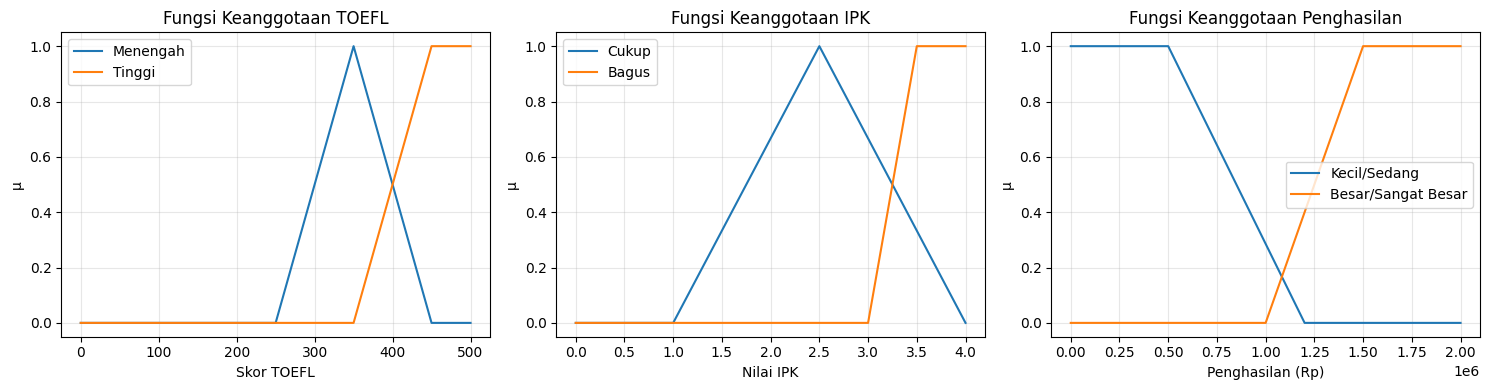

In [ ]:
def visualisasi_perbandingan():
    """Visualisasi fungsi keanggotaan input"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # TOEFL
    x_toefl = np.linspace(0, 500, 501)
    axes[0].plot(x_toefl, [fuzz_toefl_menengah(x) for x in x_toefl], label="Menengah")
    axes[0].plot(x_toefl, [fuzz_toefl_tinggi(x) for x in x_toefl], label="Tinggi")
    axes[0].set_title("Fungsi Keanggotaan TOEFL")
    axes[0].set_xlabel("Skor TOEFL")
    axes[0].set_ylabel("μ")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # IPK
    x_ipk = np.linspace(0, 4, 401)
    axes[1].plot(x_ipk, [fuzz_ipk_cukup(x) for x in x_ipk], label="Cukup")
    axes[1].plot(x_ipk, [fuzz_ipk_bagus(x) for x in x_ipk], label="Bagus")
    axes[1].set_title("Fungsi Keanggotaan IPK")
    axes[1].set_xlabel("Nilai IPK")
    axes[1].set_ylabel("μ")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Penghasilan
    x_peng = np.linspace(0, 2_000_000, 401)
    axes[2].plot(x_peng, [fuzz_penghasilan_kecil_sedang(x) for x in x_peng], label="Kecil/Sedang")
    axes[2].plot(x_peng, [fuzz_penghasilan_besar_sangat_besar(x) for x in x_peng], label="Besar/Sangat Besar")
    axes[2].set_title("Fungsi Keanggotaan Penghasilan")
    axes[2].set_xlabel("Penghasilan (Rp)")
    axes[2].set_ylabel("μ")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

visualisasi_perbandingan()

perbandingan sugeno VS mamdani

In [ ]:
def bandingkan_hasil():
    """Perbandingan hasil Mamdani vs Sugeno - Simple & Jelas"""

    hasil = []

    for _, row in df.iterrows():
        # Hitung Mamdani
        z_m, _, _ = mamdani_kelayakan(row["TOEFL"], row["IPK"], row["Penghasilan"])

        # Hitung Sugeno
        z_s, _ = sugeno_kelayakan(row["TOEFL"], row["IPK"], row["Penghasilan"])

        hasil.append({
            "NIM": row["NIM"],
            "Nama": row["Nama"],
            "Mamdani": round(z_m, 2),
            "Sugeno": round(z_s, 2),
            "Selisih": round(abs(z_m - z_s), 2)
        })

    df_hasil = pd.DataFrame(hasil)

    # Ranking
    df_hasil["Rank_Mamdani"] = df_hasil["Mamdani"].rank(ascending=False).astype(int)
    df_hasil["Rank_Sugeno"] = df_hasil["Sugeno"].rank(ascending=False).astype(int)

    # Sort by Mamdani
    df_hasil = df_hasil.sort_values("Mamdani", ascending=False).reset_index(drop=True)

    print("HASIL PERBANDINGAN MAMDANI VS SUGENO")
    print(df_hasil.to_string(index=False))

    # Statistik singkat
    print("STATISTIK")
    print(f"Rata-rata Mamdani  : {df_hasil['Mamdani'].mean():.2f}")
    print(f"Rata-rata Sugeno   : {df_hasil['Sugeno'].mean():.2f}")
    print(f"Selisih Rata-rata  : {df_hasil['Selisih'].mean():.2f}")
    print(f"Korelasi           : {df_hasil['Mamdani'].corr(df_hasil['Sugeno']):.4f}")

    # Ranking sama atau beda?
    ranking_sama = (df_hasil["Rank_Mamdani"] == df_hasil["Rank_Sugeno"]).all()
    print(f"\nRanking Identik?   : {'YA ✓' if ranking_sama else 'TIDAK ✗'}")

    return df_hasil

hasil = bandingkan_hasil()


HASIL PERBANDINGAN MAMDANI VS SUGENO
NIM       Nama  Mamdani  Sugeno  Selisih  Rank_Mamdani  Rank_Sugeno
 01      Toyes    79.69   90.83    11.14             1            1
 05       Yuni    77.83   90.33    12.51             2            2
 09    Pujiono    49.82   51.58     1.77             3            3
 04     Astuti    48.72   49.47     0.75             4            4
 08      Usman    36.20   32.79     3.41             5            5
 06 Heribertus    32.82   31.30     1.52             6            6
 02       Bowo     0.00    0.00     0.00             8            8
 03       Erna     0.00    0.00     0.00             8            8
 07        Edy     0.00    0.00     0.00             8            8
 10     Slamet     0.00    0.00     0.00             8            8
STATISTIK
Rata-rata Mamdani  : 32.51
Rata-rata Sugeno   : 34.63
Selisih Rata-rata  : 3.11
Korelasi           : 0.9950

Ranking Identik?   : YA ✓


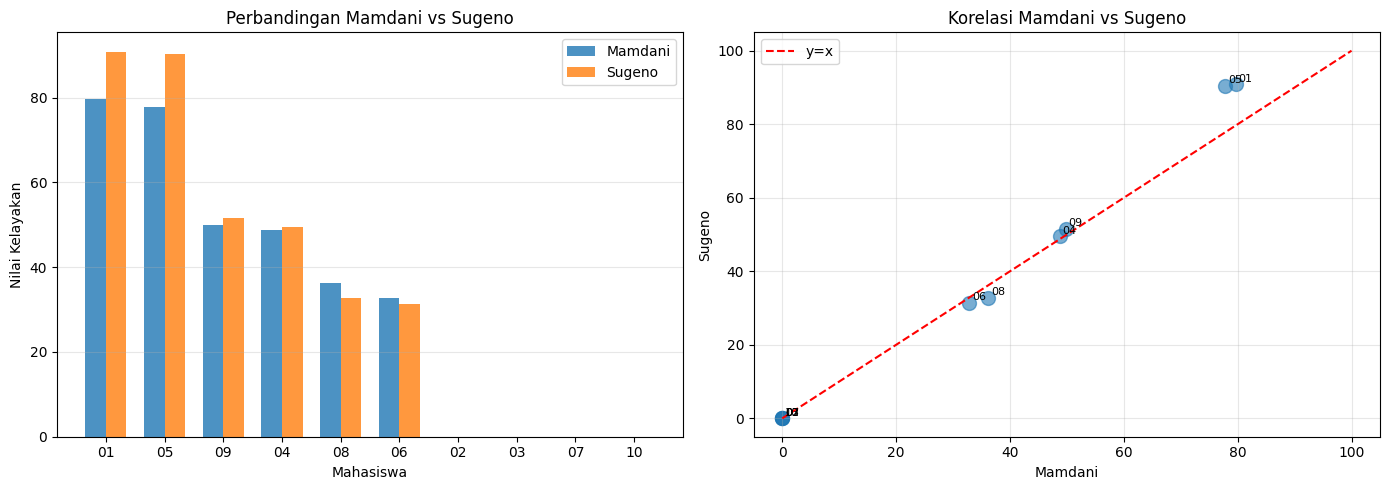

In [ ]:
def plot_perbandingan(df_hasil):
    """Visualisasi perbandingan"""

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart
    x = np.arange(len(df_hasil))
    width = 0.35
    axes[0].bar(x - width/2, df_hasil["Mamdani"], width, label='Mamdani', alpha=0.8)
    axes[0].bar(x + width/2, df_hasil["Sugeno"], width, label='Sugeno', alpha=0.8)
    axes[0].set_xlabel('Mahasiswa')
    axes[0].set_ylabel('Nilai Kelayakan')
    axes[0].set_title('Perbandingan Mamdani vs Sugeno')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_hasil["NIM"])
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Scatter plot
    axes[1].scatter(df_hasil["Mamdani"], df_hasil["Sugeno"], s=100, alpha=0.6)
    axes[1].plot([0, 100], [0, 100], 'r--', label='y=x')
    axes[1].set_xlabel('Mamdani')
    axes[1].set_ylabel('Sugeno')
    axes[1].set_title('Korelasi Mamdani vs Sugeno')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Annotate
    for idx, row in df_hasil.iterrows():
        axes[1].annotate(row['NIM'], (row['Mamdani'], row['Sugeno']),
                        fontsize=8, xytext=(2, 2), textcoords='offset points')

    plt.tight_layout()
    plt.show()

plot_perbandingan(hasil)